In [1]:
import os
import numpy as np 
import probflow as pf
from probflow.callbacks import MonitorELBO, MonitorMetric, EarlyStopping
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
import sys
sys.path.append('../')
from colorml.utils import mapping_to_target_range, get_timestamp_string, plot_predictions, huber_fn, mapping_to_target_range_sig, read_pickle, augment_data
from colorml.descriptornames import * 

RESULTS = os.path.join('..', 'results', 'baselines')
MODELS = os.path.join('..', 'models', 'baselines')
from numpy.random import seed
seed(821996)

CHEMICAL_FEATURES = metalcenter_descriptors + functionalgroup_descriptors + linker_descriptors + mol_desc  + summed_linker_descriptors + summed_metalcenter_descriptors + summed_functionalgroup_descriptors

Using TensorFlow backend.


In [452]:
def mapping_to_target_range(x, target_min=0, target_max=1):
    """Linear activation function that constrains output to a range
    
    Arguments:
        x {tensor} -- input tensor
    
    Keyword Arguments:
        target_min {float} -- minimum output (default: {0})
        target_max {float} -- maximum output (default: {1})
    
    Returns:
        tensor -- constrained linear activation
    """
    x02 = x + 1  # x in range(0,2)
    scale = (target_max - target_min) / 2.0
    return x02 * scale + target_min

In [453]:
import tensorflow_addons as tfa
 
class DenseNetwork2(pf.Module):

    def __init__(self, dims, activation=tf.keras.activations.relu):
        Nl = len(dims)-1 #number of layers
        self.layers = [pf.modules.Dense(dims[i], dims[i+1]) for i in range(Nl)]
        self.activations = (Nl-1)*[activation] + [mapping_to_target_range]

    def __call__(self, x):
        for i in range(len(self.activations)):
            x = self.layers[i](x)
            x = self.activations[i](x)
        return x

In [454]:
import tensorflow_addons as tfa
 
class DenseNetwork(pf.Module):

    def __init__(self, dims, activation=tf.keras.activations.relu):
        Nl = len(dims)-1 #number of layers
        self.layers = [pf.modules.Dense(dims[i], dims[i+1]) for i in range(Nl)]
        self.activations = (Nl-1)*[activation] + [lambda x: x]

    def __call__(self, x):
        for i in range(len(self.activations)):
            x = self.layers[i](x)
            x = self.activations[i](x)
        return x

In [455]:
df_subset_merged = pd.read_csv('../data/color_feat_merged.csv')

In [456]:
augment_dict = read_pickle('../data/augment_dict.pkl')

In [457]:
df_train, df_test = train_test_split(df_subset_merged, train_size=0.7)

In [458]:
df_train = augment_data(df_train, augment_dict)

In [459]:
X_train = df_train[CHEMICAL_FEATURES]
y_train = df_train[['r', 'g', 'b']]

X_test = df_test[CHEMICAL_FEATURES]
y_test = df_test[['r', 'g', 'b']]

In [460]:
name_train = df_train['color_cleaned']
name_test = df_test['color_cleaned']

In [461]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [462]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.9)

In [463]:
y_train = y_train / 255
y_valid = y_valid / 255
y_test = y_test / 255

In [464]:
class DensityNetwork(pf.ContinuousModel):

    def __init__(self, units, head_units):
        self.core = DenseNetwork(units)
        self.mean = DenseNetwork2(head_units)
        self.std  = DenseNetwork2(head_units)
        self.batch_norm = pf.modules.BatchNormalization([units[-1]])
        
    def __call__(self, x):
        x = self.core(x)
        x = self.batch_norm(x)
        return pf.Normal(self.mean(x), tf.exp(self.std(x)))

# Create the model
model = DensityNetwork([X_train.shape[1], 64, 16], [16, 8, 6, 3])

monitor_mae = MonitorMetric('mae', X_valid, y_valid, verbose=True)
monitor_elbo = MonitorELBO()
early_stopping = EarlyStopping(lambda: monitor_mae.current_metric, patience=10)

# Fit it!
model.fit(X_train, y_train, callbacks=[monitor_mae, monitor_elbo, early_stopping], batch_size=268, epochs=500)

Epoch 1 	mae: 0.38450588972663846
Epoch 2 	mae: 0.3827575615687112
Epoch 3 	mae: 0.3761274192627017
Epoch 4 	mae: 0.37245846400721183
Epoch 5 	mae: 0.36652345640994677
Epoch 6 	mae: 0.36608890815784445
Epoch 7 	mae: 0.36435087505119185
Epoch 8 	mae: 0.363465667342282
Epoch 9 	mae: 0.35992375866062537
Epoch 10 	mae: 0.3589722801709191
Epoch 11 	mae: 0.3534578067842997
Epoch 12 	mae: 0.3473422908731097
Epoch 13 	mae: 0.34689468542884594
Epoch 14 	mae: 0.3419979275114501
Epoch 15 	mae: 0.33601763120235273
Epoch 16 	mae: 0.3296769908345291
Epoch 17 	mae: 0.3240574387863599
Epoch 18 	mae: 0.31206972629429175
Epoch 19 	mae: 0.3064801070091546
Epoch 20 	mae: 0.30123058227748895
Epoch 21 	mae: 0.2905660357309412
Epoch 22 	mae: 0.2791482696117235
Epoch 23 	mae: 0.2733396717284559
Epoch 24 	mae: 0.27318915651954545
Epoch 25 	mae: 0.2772570868883811
Epoch 26 	mae: 0.2796588327812859
Epoch 27 	mae: 0.28153727436830484
Epoch 28 	mae: 0.281882532129066
Epoch 29 	mae: 0.28007139550132604
Epoch 30 	ma

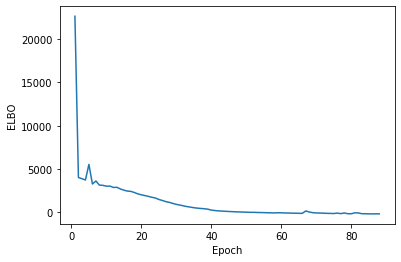

In [465]:
monitor_elbo.plot()

In [466]:
model.metric("mae", X_test, y_test)

0.32961118942207235

In [467]:
model.aleatoric_interval(X_test[10:20, :].astype(np.float32))[0] * 255 - model.aleatoric_interval(X_test[10:20, :].astype(np.float32))[1] * 255

array([[-148.66427761, -179.67429792, -335.07753501],
       [-135.81884839, -168.10741858, -327.33461031],
       [-340.29129794, -329.29844145, -430.57447884],
       [-343.28009672, -330.62196971, -426.83223141],
       [-165.33342683, -212.41519925, -365.82428511],
       [ -13.5077371 ,  -25.5205759 , -171.48070258],
       [-407.63867549, -352.63782229, -378.5283471 ],
       [-209.7816474 , -236.08348816, -391.00136818],
       [-350.86813717, -326.07046641, -395.98914888],
       [-315.95121002, -304.57604389, -380.68109688]])

In [468]:
model.predict(X_test[10:20, :].astype(np.float32))

array([[0.8554883 , 0.81143916, 0.7230355 ],
       [0.8554883 , 0.81143916, 0.7230355 ],
       [0.6623061 , 0.6212933 , 0.57314956],
       [0.59104335, 0.5511507 , 0.5178584 ],
       [0.83440983, 0.79069203, 0.7066812 ],
       [0.8554883 , 0.81143916, 0.7230355 ],
       [0.42841747, 0.3910809 , 0.39168042],
       [0.81680584, 0.77336466, 0.6930226 ],
       [0.51522493, 0.4765239 , 0.45903248],
       [0.44960734, 0.41193768, 0.40812123]], dtype=float32)

In [469]:
import seaborn as sns

(0, 255)

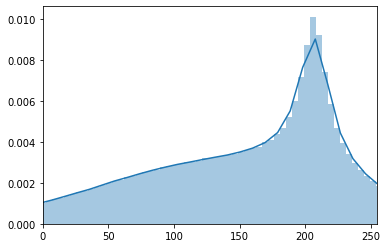

In [470]:
sns.distplot(
    model.predictive_sample(X_test[0:1, :].astype(np.float32), ).reshape(-1,3)[:, 1] *255, 
    bins=200   
)


plt.xlim(0,255)